In [3]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import uproot
import tqdm
import time
import seaborn as sns
colors = sns.color_palette('colorblind')
#import matplotlib as mpl
#mpl.style.use("/Users/pinguino/paper.mplstyle")

In [13]:
# # remote mount the GRAMS directory on local machine (requires SSHFS)
# host = "ub"
# remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
# GRAMSdir = os.path.expanduser("~/remote_mount")
# os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# # mount and unmount commands
# mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
# unmount = f"umount {GRAMSdir}"

# try:
#     # make sure the directory is not currently mounted, then mount
#     subprocess.run(unmount, shell=True, check=True)
#     subprocess.run(mount, shell=True, check=True)
# except:
#     # otherwise just directly mount
#     subprocess.run(mount, shell=True, check=True)

In [4]:
# alternatively, set this directory manually:
GRAMSdir = os.path.expanduser("~/Software/GRAMS/pGRAMS_code/pGRAMS-Readout-Integration")
#GRAMSdir = os.path.expanduser("./")

In [5]:
#With Numpy
# SET TEST DIRECTORY:
testdir = "readout_test_51624"

# load CSV and extract trees into dictionary
csv = pd.read_csv(f"{GRAMSdir}/{testdir}/{testdir}.csv")
filenames = csv['File ID'].tolist()
df_dict = {};

for filename in tqdm.tqdm(filenames, desc=f'extracting ADC data...', total=len(filenames)):
    file = uproot.open(f"{GRAMSdir}/{testdir}/outfile_{filename}.root")
    tree = file["adc_tree"]
    df_dict[filename]=tree.arrays(library="np")

extracting ADC data...: 100%|██████████| 96/96 [00:03<00:00, 25.98it/s]


## Waveform Plotter

In [6]:
def waveform_plotter(file_list, active_ch, event_id, overlay=1, average=0):
# inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    if average == 1:
        # create empty list of adc counts (and square of adc counts) of nsamples
        temp = df_dict[file_list[0]]
        ev_ch_mask = np.logical_and((temp['event_id'] == 1), (temp['channel_id'] == 1))       
        sum_counts = np.zeros(len(temp['adc_count'][ev_ch_mask]))
        sum_squares    = np.zeros(len(temp['adc_count'][ev_ch_mask]))  
    elif average == 0:
        figure = plt.figure(figsize=[9,6])

    for filename in file_list:
        df = df_dict[filename]
        # find FEM for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # slice dataframe for FEM and desired channel and event
        fem_mask = df['fem_id']==fem_id
        mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==event_id, df['channel_id']==active_ch))

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(len(df['adc_count'][mask]))

        # sum counts if average is enabled
        if average == 1: 
            adc_counts = df['adc_count'][mask]
            sum_counts += adc_counts
            sum_squares += adc_counts ** 2

        if average == 0 and overlay == 1:
            # if overlay is enabled, plot on the same figure
            plt.plot(time, df['adc_count'][mask], label=f'Run {filename}')
        elif average == 0 and overlay ==0:
            # if overlay is disabled, new figure for each run
            plt.figure()
            plt.plot(time, mask['adc_count'])
            plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}, Run {filename}')
            plt.xlabel('Time (us)')
            plt.ylabel('ADC Counts')
            plt.xlim(time.min(), time.max())
            plt.ylim(0, 4095)
            plt.grid(True)
            plt.show()

    if average == 1:
        # Calculate the average waveform
        average_counts = sum_counts / len(file_list)
        # Calculate the standard deviation waveform
        variance = (sum_squares / len(file_list)) - (average_counts ** 2)
        std_deviation = np.sqrt(variance)

        # plot the average waveform
        plt.figure()
        plt.plot(time, average_counts, color=colors[0],label='Average ADC Counts')
        plt.fill_between(time, average_counts - std_deviation, average_counts + std_deviation, color = colors[0], alpha=0.3, label='Std Dev')
        plt.title(f'Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()  
    elif average == 0 and overlay == 1:
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return

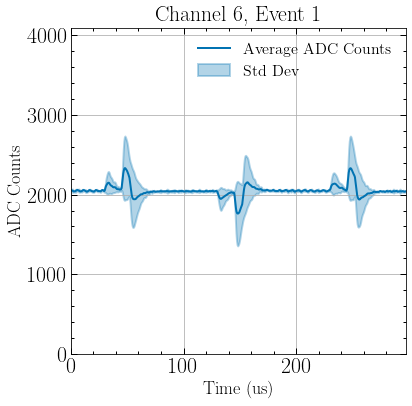

In [7]:
# set inputs, run plotter
file_list = [450, 451, 452]
active_ch = 6
event_id = 1

waveform_plotter(file_list, active_ch=6, event_id=1, overlay=1, average=1)

## ADC Calibration

In [20]:
def findpeaks(channels):
    peaks = dict()
    Q = dict()
    for ch in channels:
        # extract file_list and pulse heights for given channel
        mask_ch = csv[csv['ADC Ch.'].isin([ch])]
        file_list = mask_ch['File ID'].tolist()
        mV = mask_ch['Input (mVpp)'].tolist()
        
        # convert mV to charge
        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
        
        peaks[ch] = []
        for filename in file_list:
            df = df_dict[filename]

            # find FEM for run
            fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
            
            # slice dataframe for FEM and desired channel, find max height for each event
            mask = np.logical_and(df['fem_id'] == fem_id ,df['channel_id'] == ch)
            
            event_ids = np.unique(df['event_id'][mask])
            max_counts = []
            for event in event_ids:
                mask = df['event_id']==event
                max_counts = np.max(np.abs(df['adc_count'][mask] - 2048))+2048
            peaks[ch].append(max_counts.mean())
            
    return peaks, Q

### ADC Peaks vs. Input Charge Plotter

In [21]:
def plot_peaks_vs_Q(channels, overlay=1):
    peaks, Q = findpeaks(channels)
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in channels]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(fontsize=22)
        plt.show()
    else:
        for c in active_ch:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            plt.legend(fontsize=22)
            plt.show()
            
    return figure

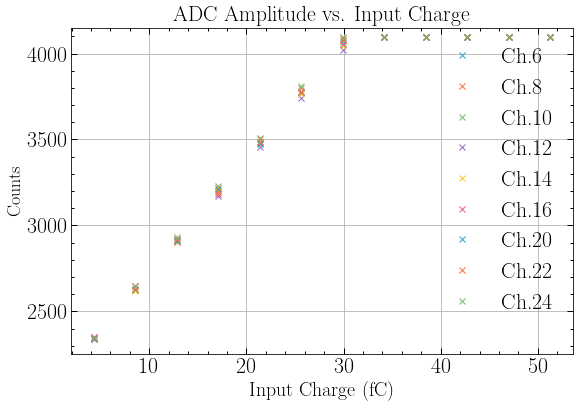

In [22]:
# set inputs and run functions
channels = [6, 8, 10, 12, 14, 16, 20, 22, 24]
my_figure = plot_peaks_vs_Q(channels, overlay=1)

In [23]:
# add noise, saturation, and MIP bound to plot (only if they don't already exist)
if not any(line.get_label() == 'Saturation' for line in ax.get_lines()):
    ax.axhline(y=4095, color='r', linestyle='--', label='Saturation')
if not any(line.get_label() == 'MIP' for line in ax.get_lines()):
    ax.axvline(x=4.27, color='b', linestyle='--', label='MIP')
# if not any(line.get_label() == 'Noise' for line in ax.get_lines()):
#     ax.axhline(y=4095, color='r', linestyle='--', label='Noise')

ax.legend()
ampQ

NameError: name 'ax' is not defined

### Linear Fitting

In [ ]:
# hold off on editing this

66.53829787287077 2061.1000000842514


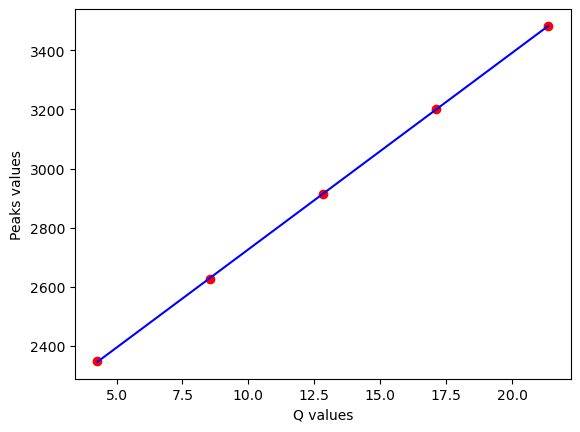

In [90]:
# def linearity(channels):
peaks, Q = findpeaks([6])

def line(params, x):
    m, b = params
    return m * x + b

def objective(params, x, y):
    return np.sum((y - line(params, x)) ** 2)
    
guess = [1.0, 2048.0]
range = 5 # only look at the first 5 data points (approximate linear region)
peaksrange = np.array(peaks[6][:range])
Qrange = np.array(Q[6][:range])

# perform the minimization
result = minimize(objective, guess, args=(Qrange, peaksrange))

# results
m, b = result.x
print(m, b)

# plot
plt.scatter(Qrange, peaksrange, color='red')
plt.plot(Qrange, line([m, b], Qrange), color='blue')
plt.xlabel('Q values')
plt.ylabel('Peaks values')
plt.show()

In [ ]:
resolution = m

Cin = 1 # preamp input capacitance, in pF
dyn_range = (resolution*4096)/

Vdiv = (1/11) # preamp voltage divider
Cin = 1 
Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC

## Noise

In [33]:
# noise rms plot; take baseline rms for each channel (with minimal crosstalk, i.e. when the active channel is furthest away)
#Plot average and std_dev noise counts on a specified channel as a function of time

def plot_counts_on_channel(file_list, active_ch):
#inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    # create empty list of adc counts (and square of adc counts) of nsamples
    temp = df_dict[file_list[0]]
    ev_ch_mask = np.logical_and((temp['event_id'] == 1), (temp['channel_id'] == 1))       
    sum_counts = np.zeros(len(temp['adc_count'][ev_ch_mask]))
    sum_squares    = np.zeros(len(temp['adc_count'][ev_ch_mask]))  
    nsamps = len(sum_counts)
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id
        
        all_evs = np.unique(df['event_id'])

        #for every event
        for ev in all_evs:
            nloops+=1
            mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==active_ch))
            adc_counts = df['adc_count'][mask]
            if(len(adc_counts)!=nsamps):
                print('Ch: {} Event: {} FEM: {} Found missing adc counts. {} instead of {}'.format(ch, ev, fem_id, len(adc_counts), nsamps))
            else:
                sum_counts += adc_counts
                sum_squares += adc_counts ** 2

    # create time axis (2 MHz sampling rate -> 0.5 us steps)
    time = 0.5*np.arange(nsamps)

    # Calculate the average waveform
    average_counts = sum_counts / nloops
    # Calculate the standard deviation waveform
    variance = (sum_squares / nloops) - (average_counts ** 2)
    std_deviation = np.sqrt(variance)

    baseline=2048
    
    # plot the average waveform
    plt.plot(time, average_counts, color=colors[0],label='Average ADC Counts')
    plt.fill_between(time, average_counts - std_deviation, average_counts + std_deviation, color = colors[0], alpha=0.3, label='Std Dev')
    plt.title(f'Channel {active_ch}')
    plt.xlabel('Time (us)')
    plt.ylabel('ADC Counts')
    plt.axhline(baseline, color='k', ls='--', alpha=0.5, label='Baseline')
    plt.xlim(time.min(), time.max())
    plt.ylim(baseline-20, baseline+20)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return

# Plot ADC counts vs time averaging over all events for a channel

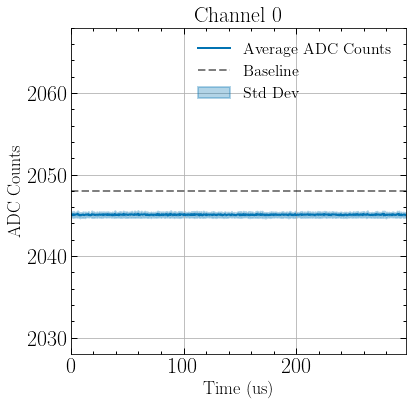

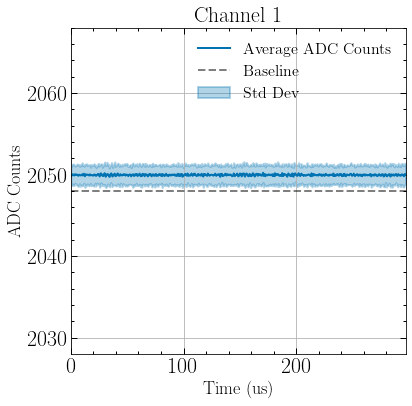

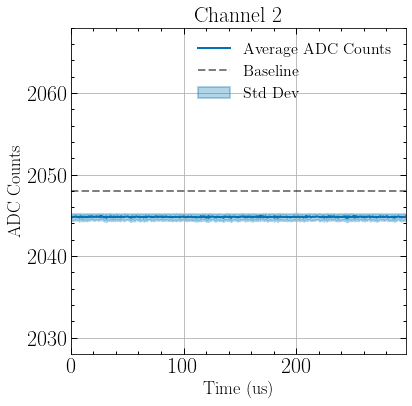

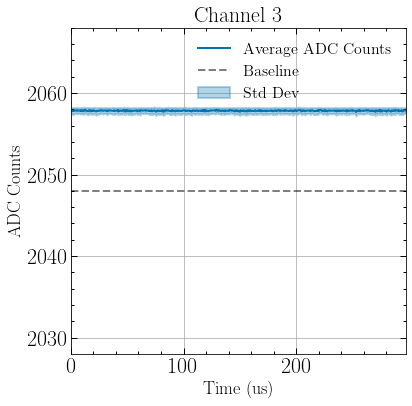

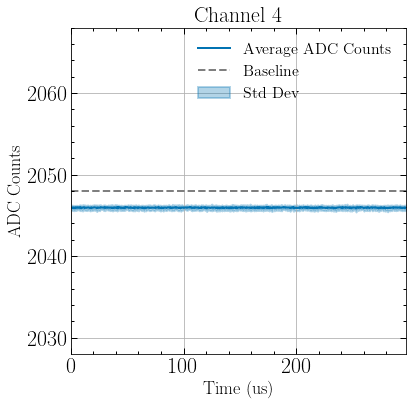

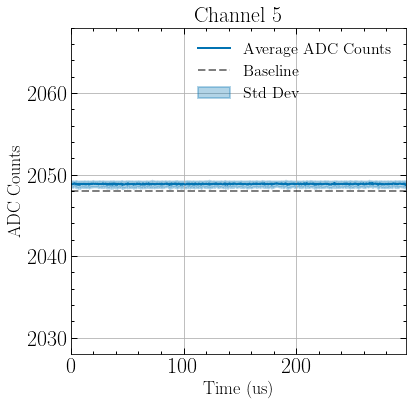

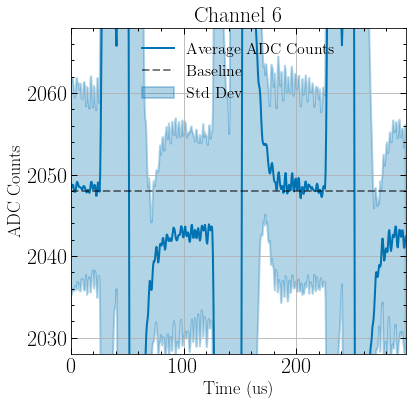

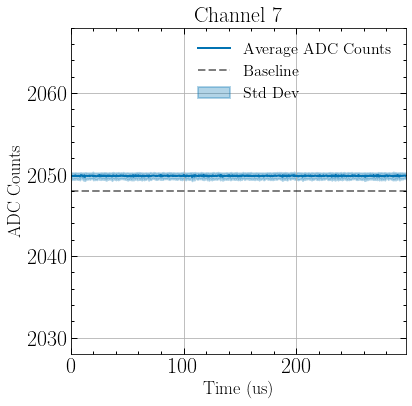

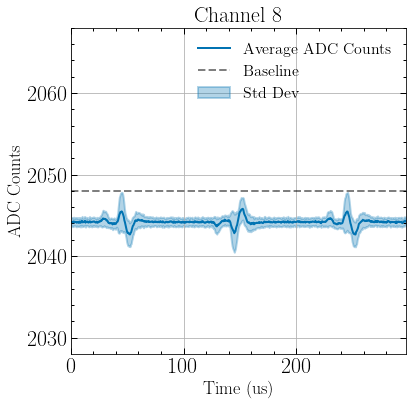

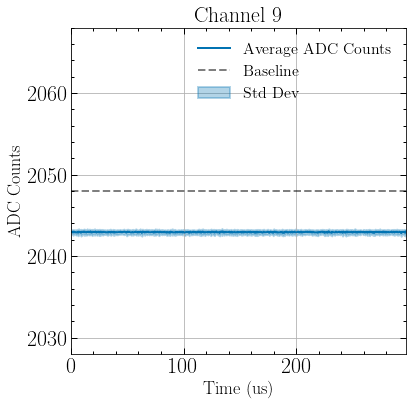

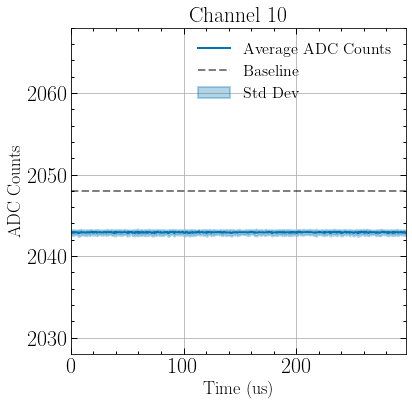

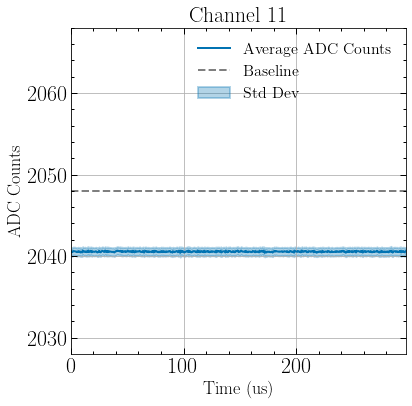

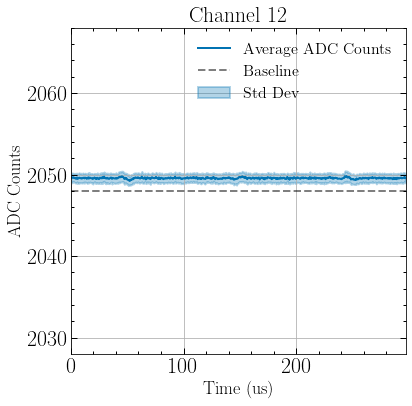

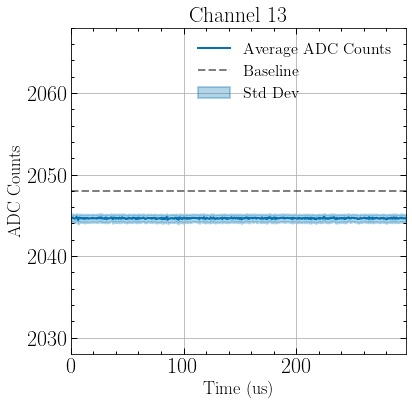

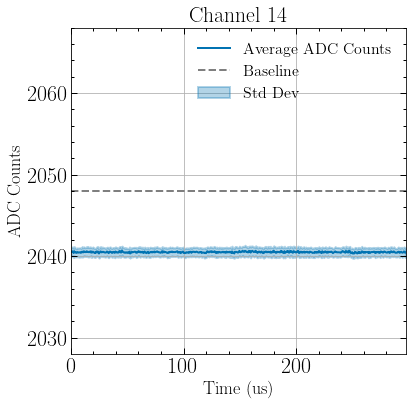

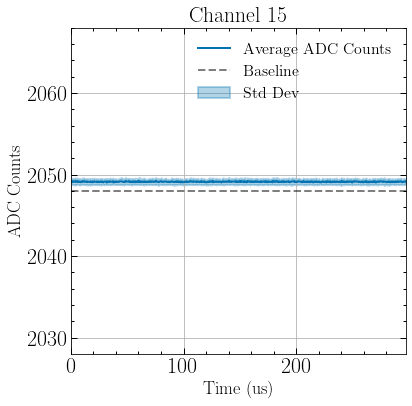

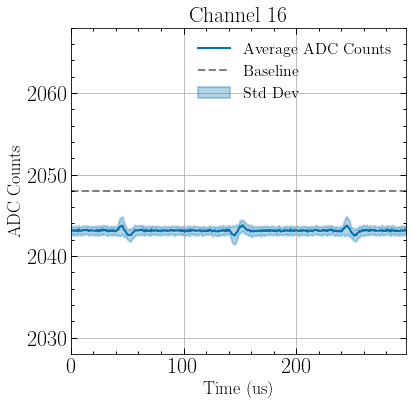

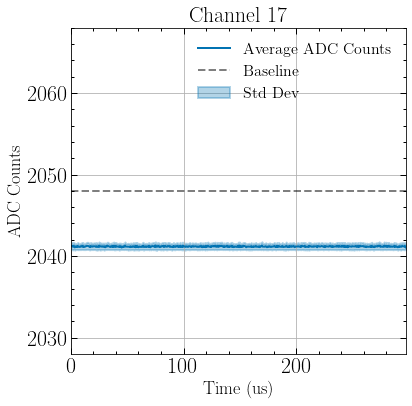

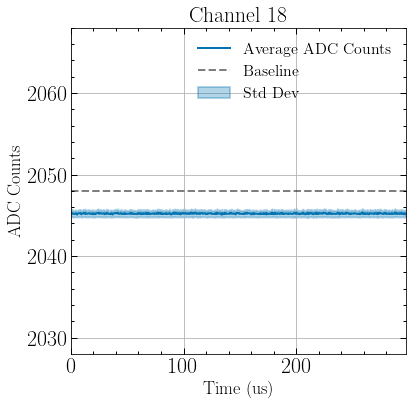

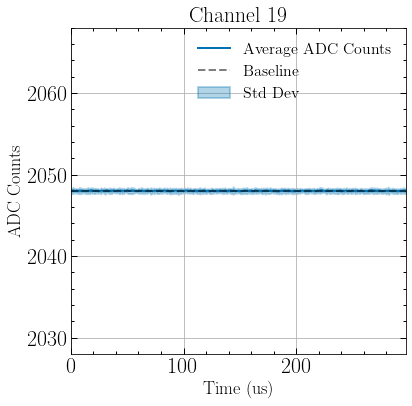

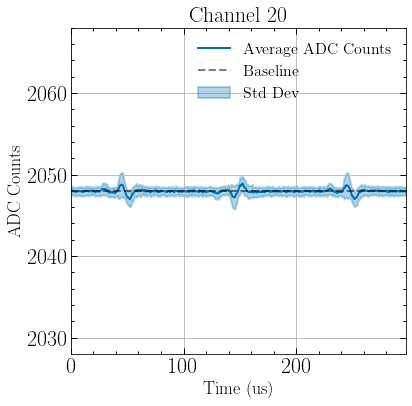

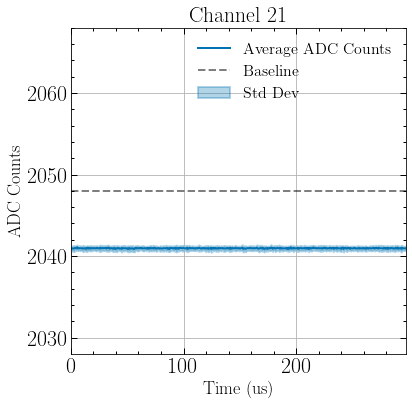

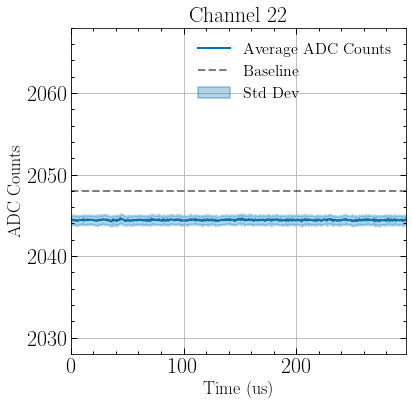

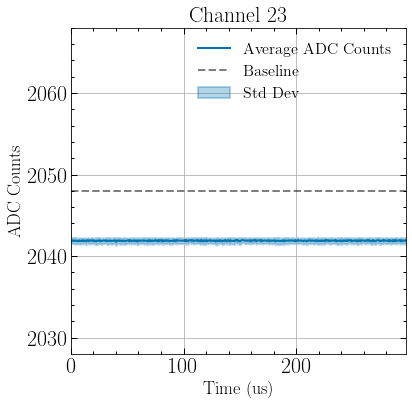

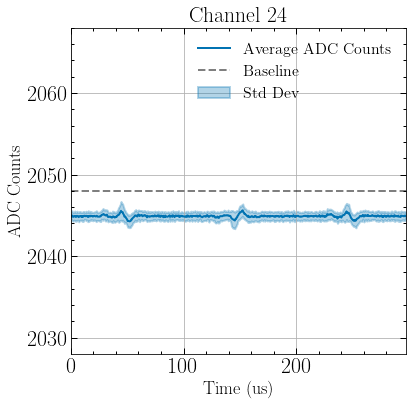

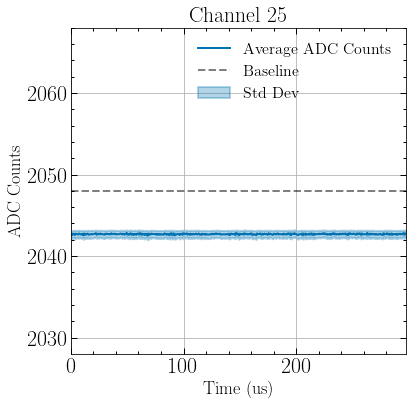

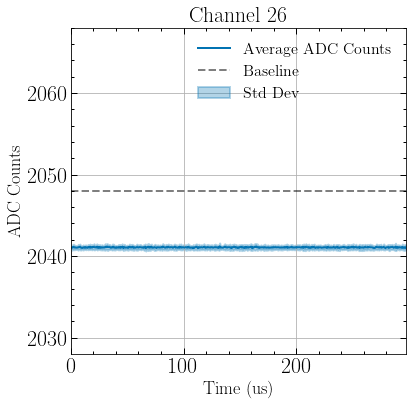

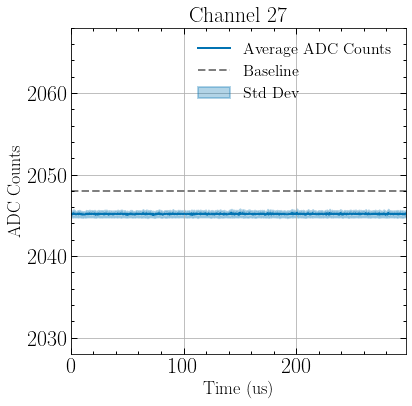

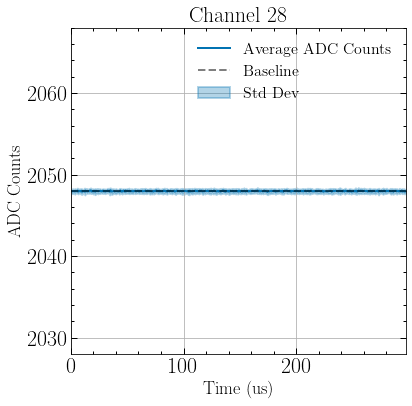

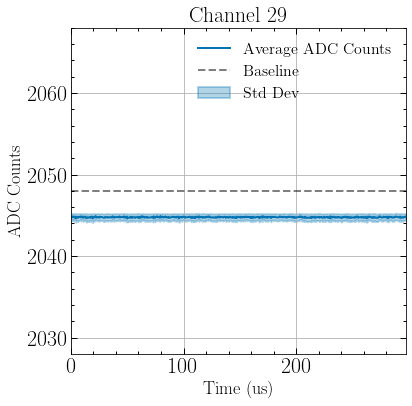

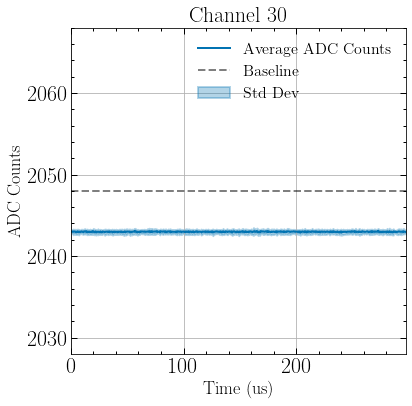

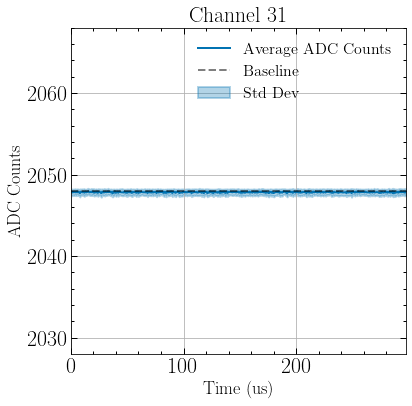

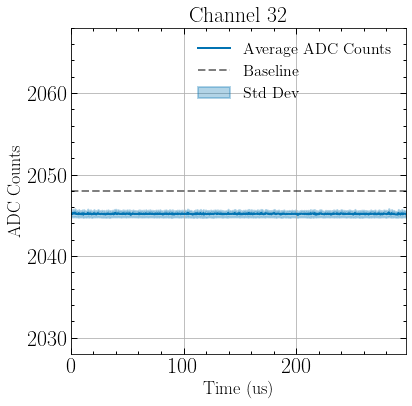

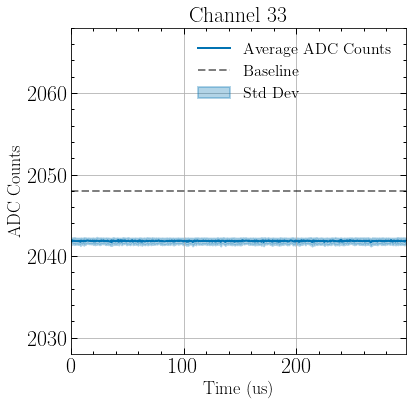

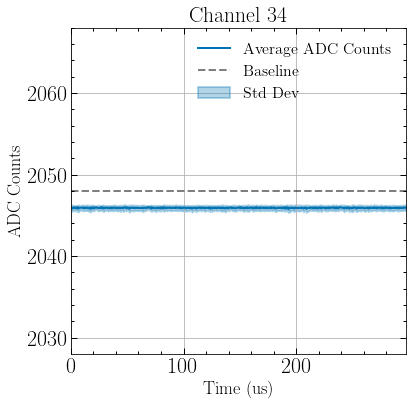

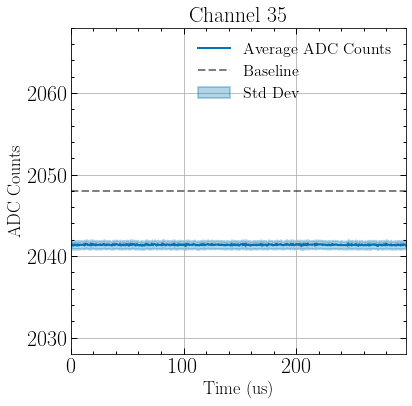

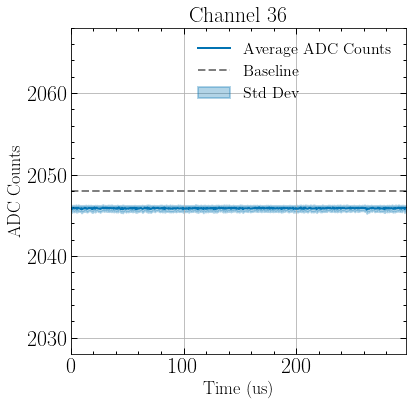

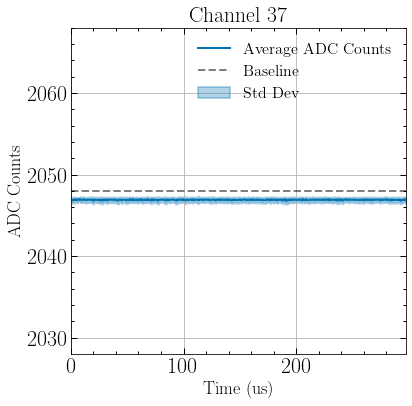

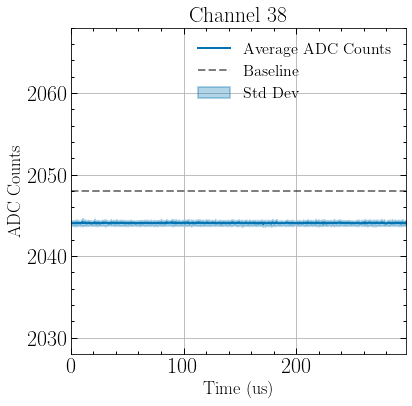

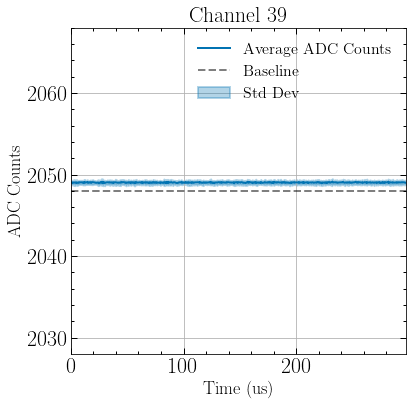

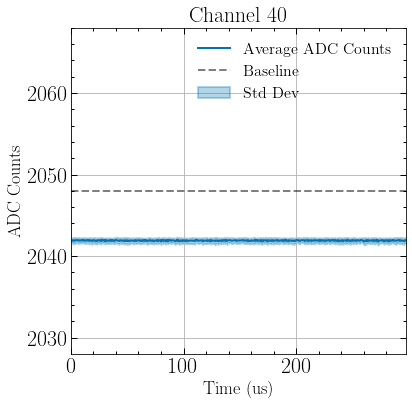

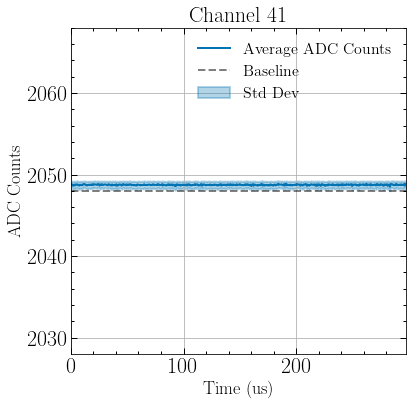

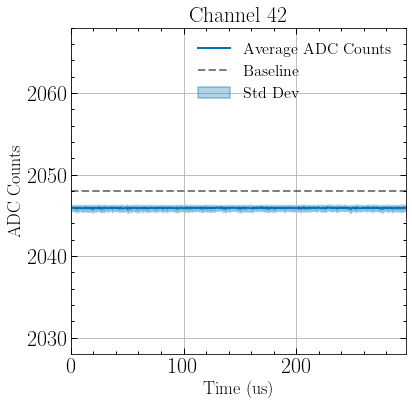

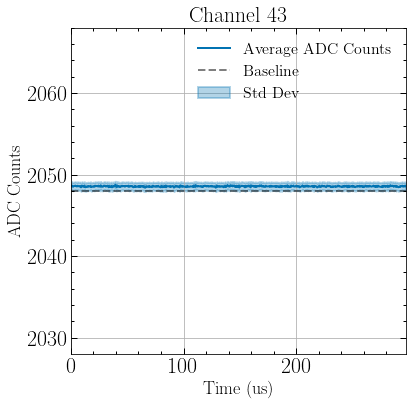

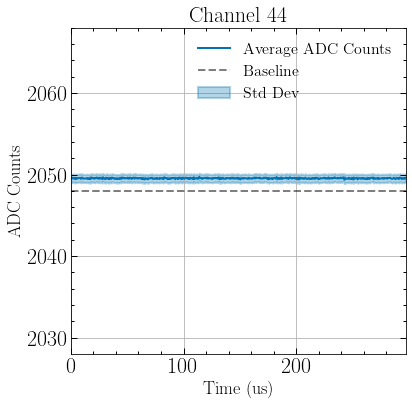

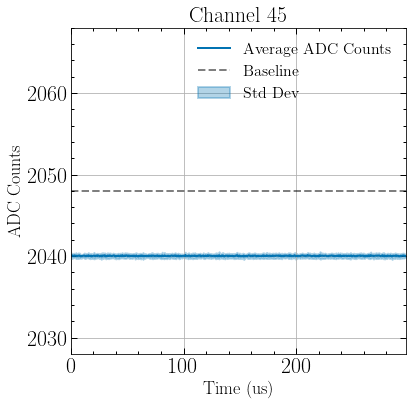

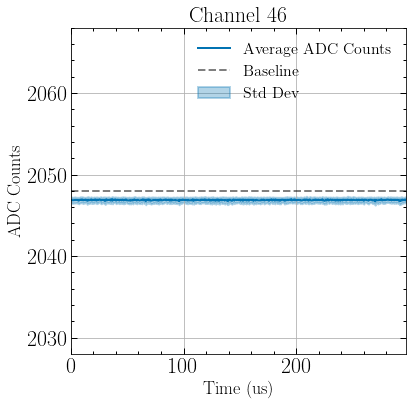

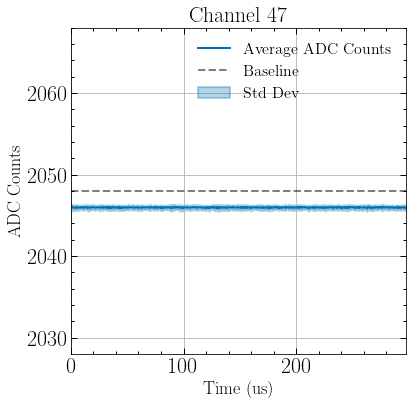

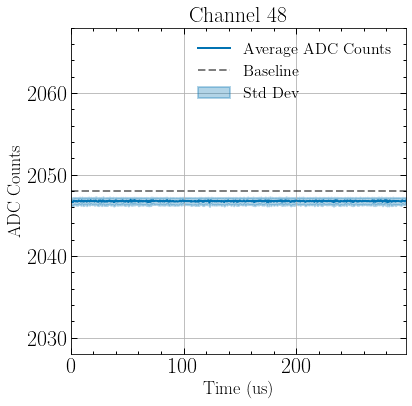

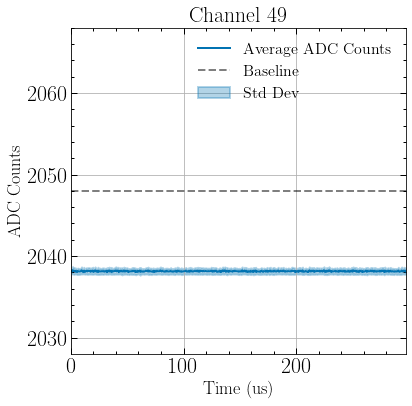

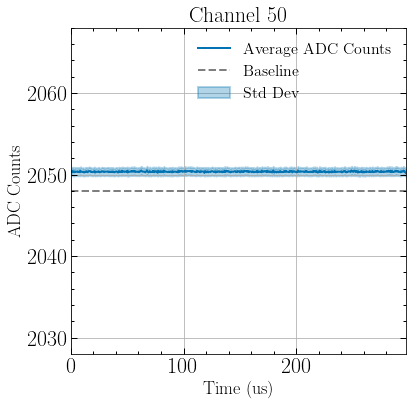

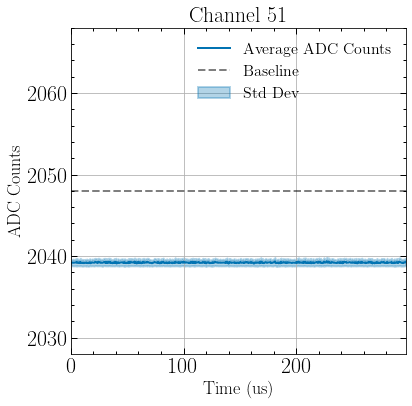

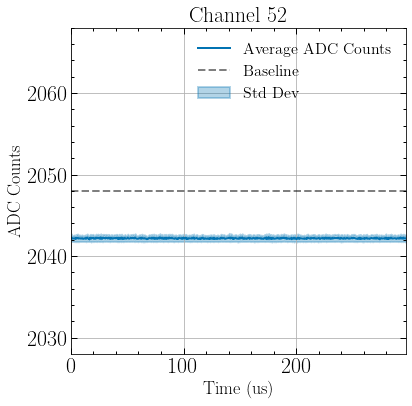

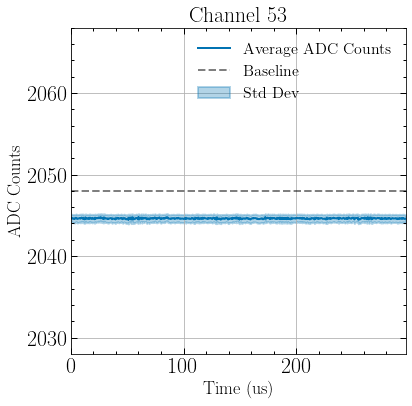

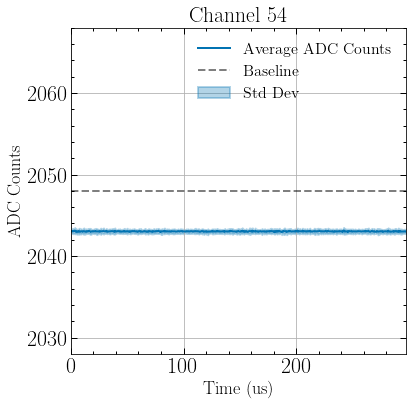

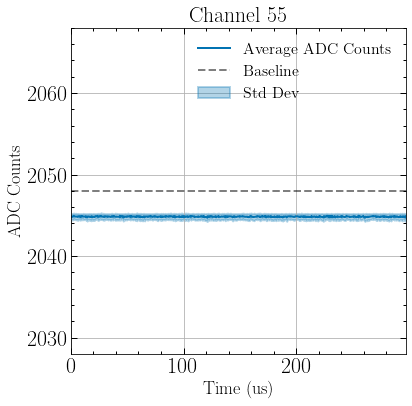

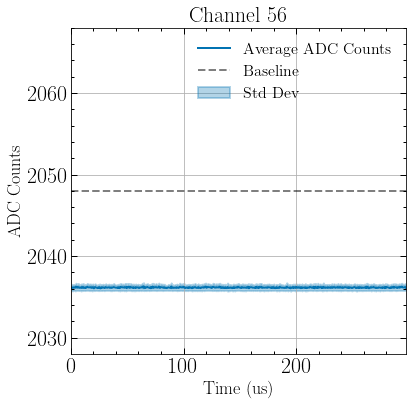

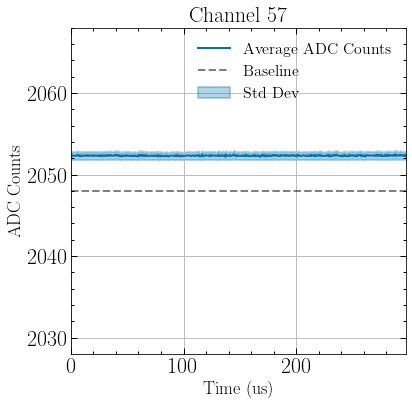

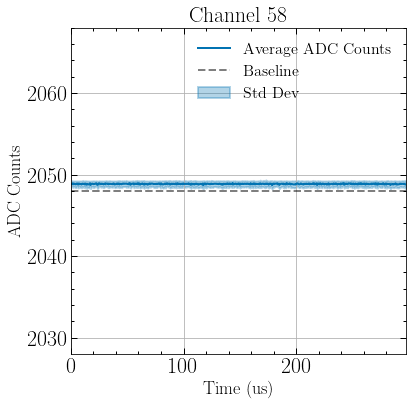

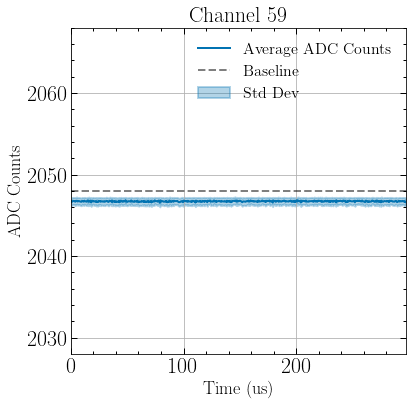

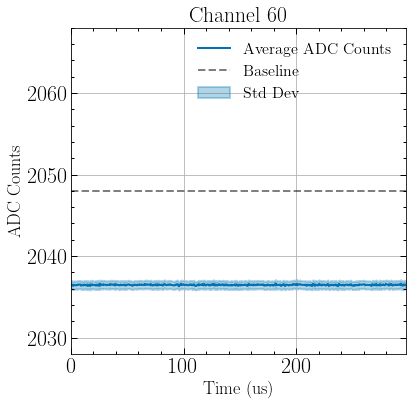

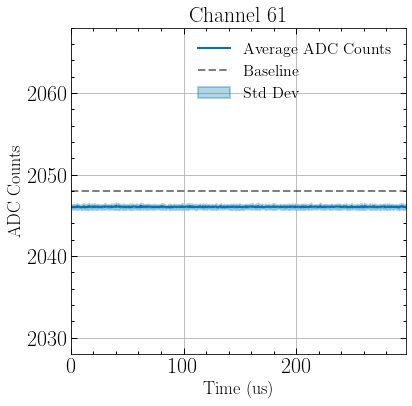

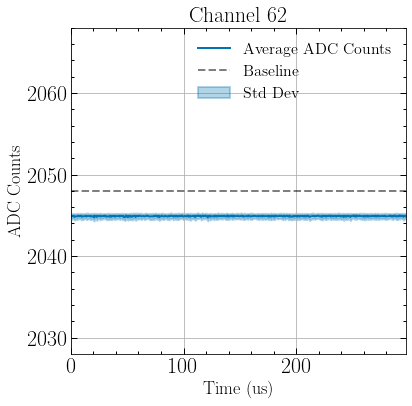

Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595
Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595
Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595


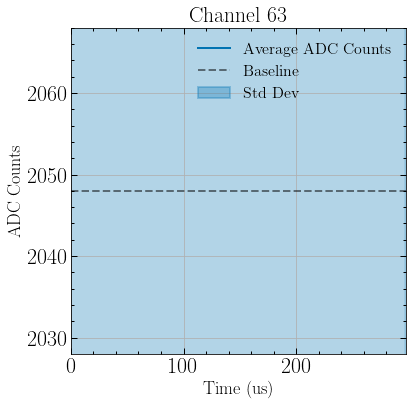

In [34]:
channels=np.arange(0, 64, 1)
for ch in channels:
    plot_counts_on_channel(file_list, ch)

In [26]:
#Get noise counts for all channels (except for active one) for noise measurements

def noise_counts(file_list, active_ch):
#inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    counts = dict()
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id

        #get all event ids in file
        all_evs = np.unique(df['event_id'])
        
        #remove any active channel if passed
        all_chs = np.unique(df['channel_id'])
        non_active = np.delete(all_chs, np.where(all_chs==active_ch)[0][0])

        #loop over channels
        for ch in non_active:
            counts[ch] = []
            nloops+=1
            #loop over events
            for ev in all_evs:
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==ch))
                adc_counts = df['adc_count'][mask]
                if nloops<2:
                    nsamps = len(adc_counts)
                if(len(adc_counts)!=nsamps):
                    print('Skipping Ch: {} Event: {}. Found {} missing samples'.format(ch, ev, abs(len(adc_counts)-nsamps)))
                else:
                    counts[ch].append(adc_counts)
                    #sum_squares.append(adc_counts ** 2)
        
        channels = [key for key in counts.keys()]
        counts = {ch: np.concatenate(counts[ch]) for ch in channels}

    return counts

In [27]:
counts = noise_counts(file_list, active_ch)

Skipping Ch: 63 Event: 25. Found 47 missing samples
Skipping Ch: 63 Event: 25. Found 47 missing samples
Skipping Ch: 63 Event: 25. Found 47 missing samples


In [29]:
# Plot noise histogram for every channel

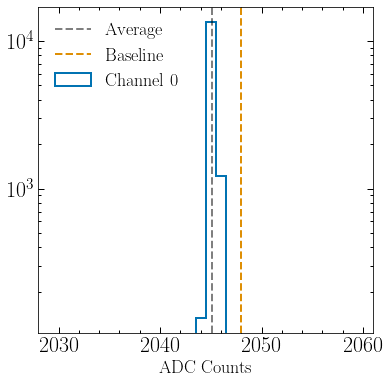

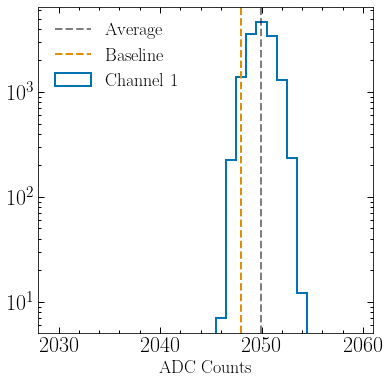

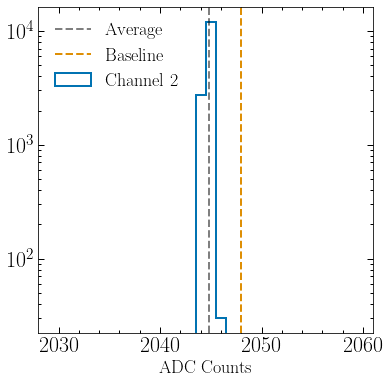

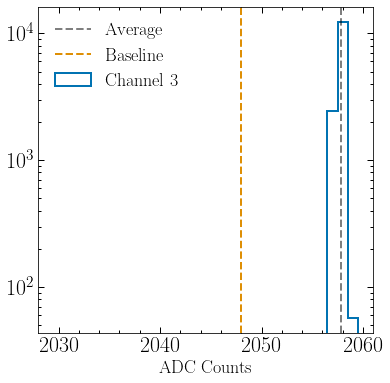

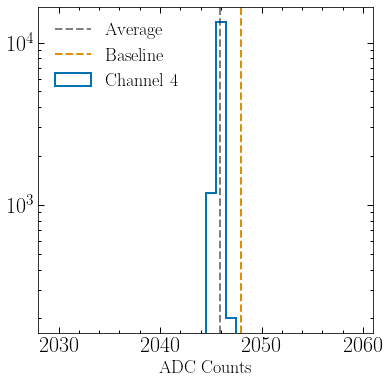

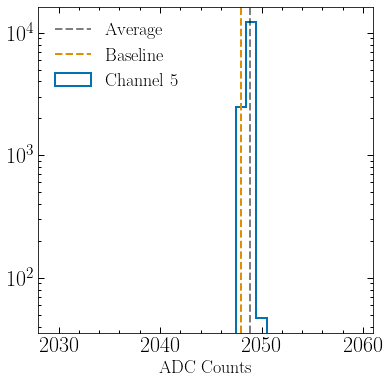

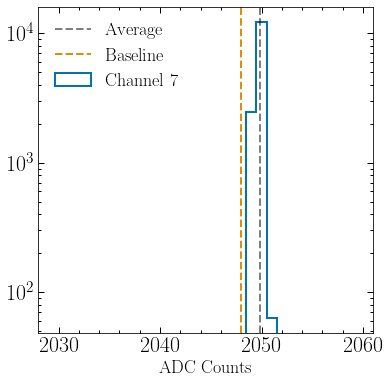

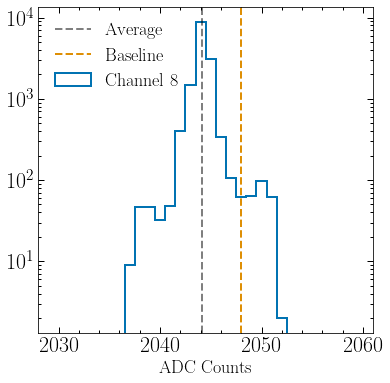

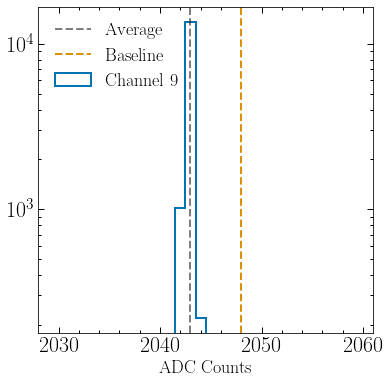

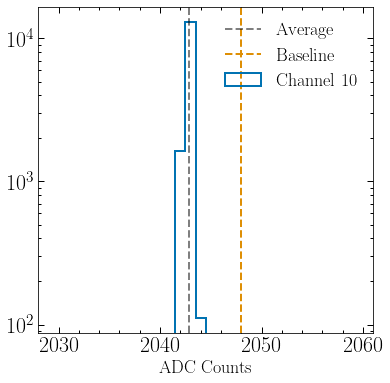

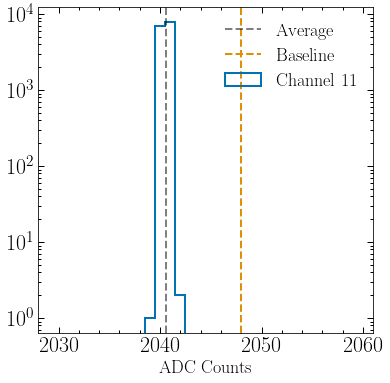

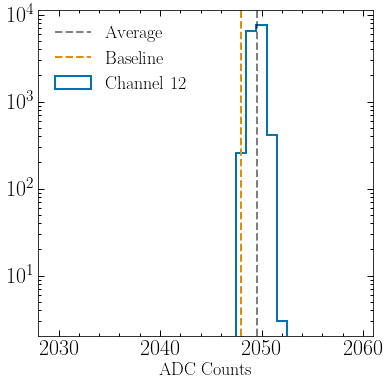

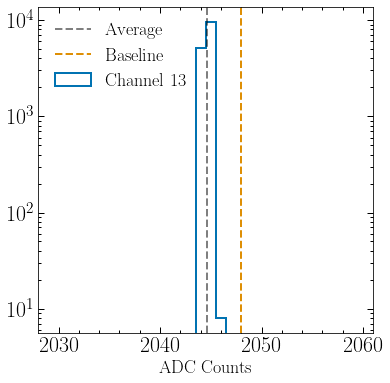

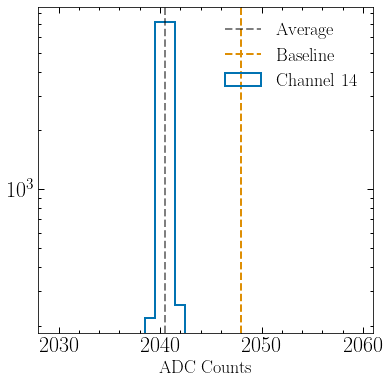

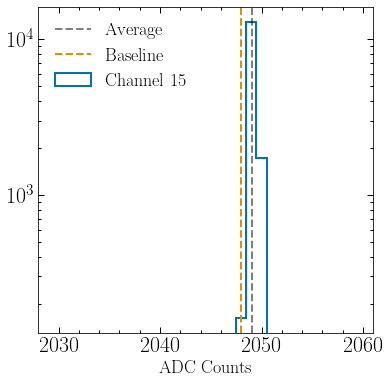

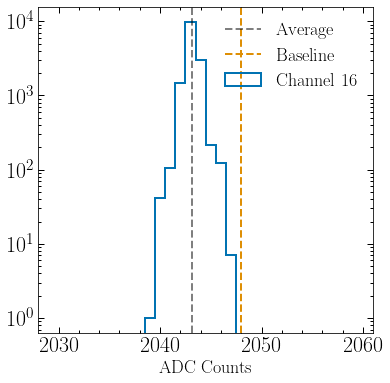

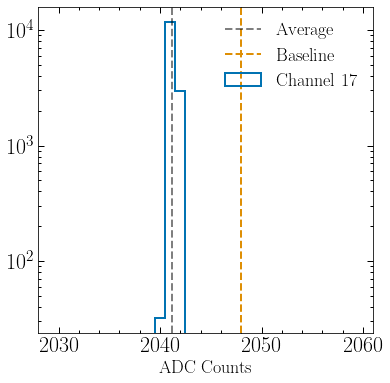

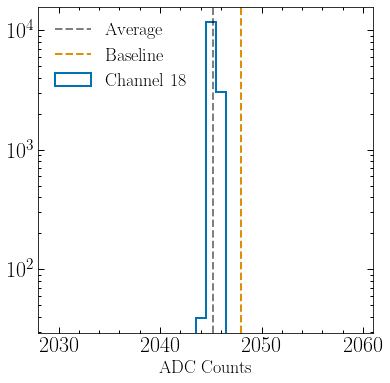

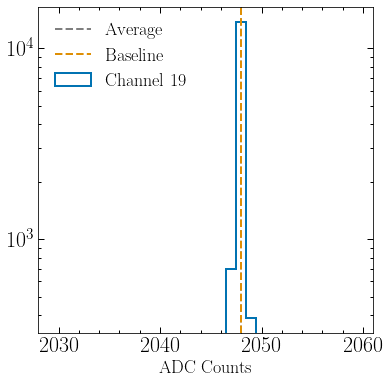

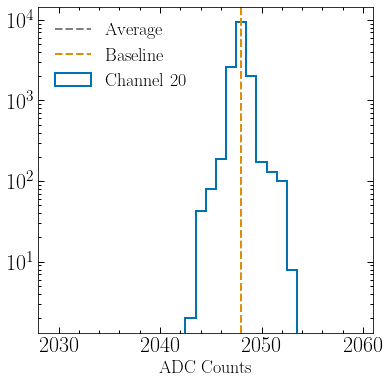

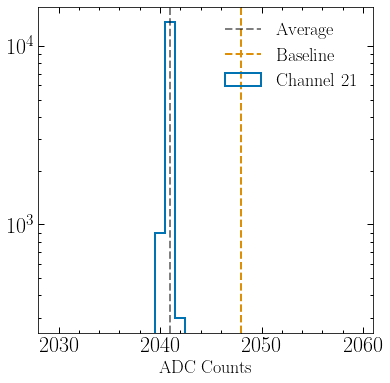

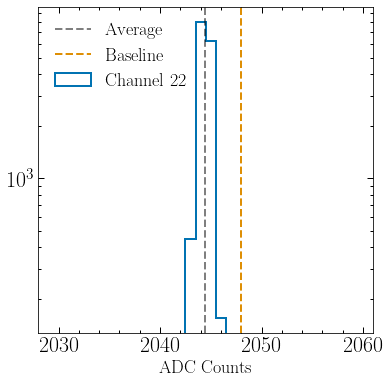

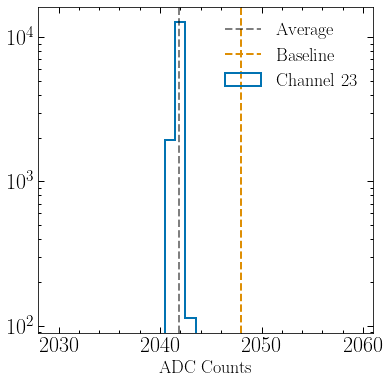

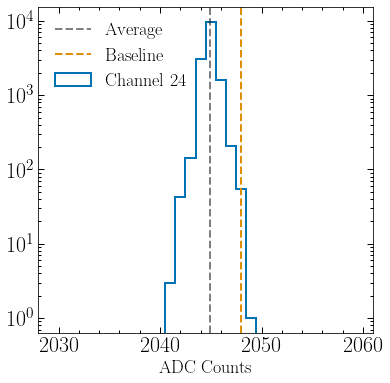

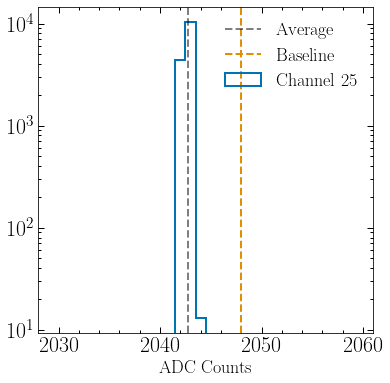

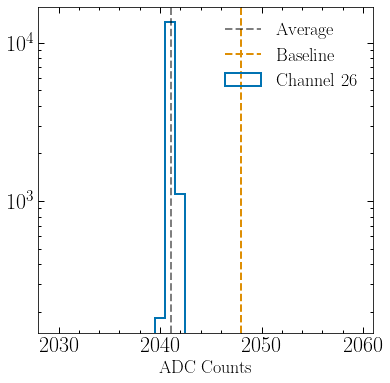

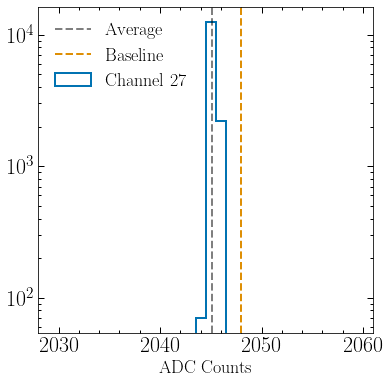

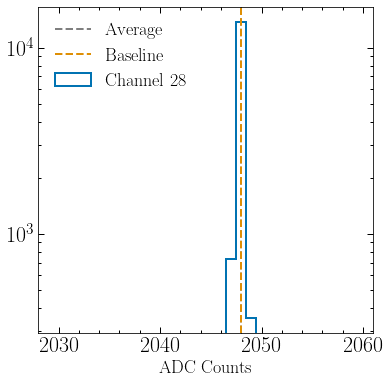

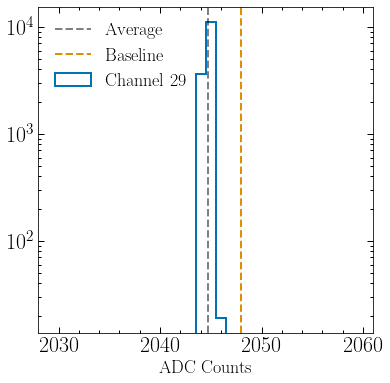

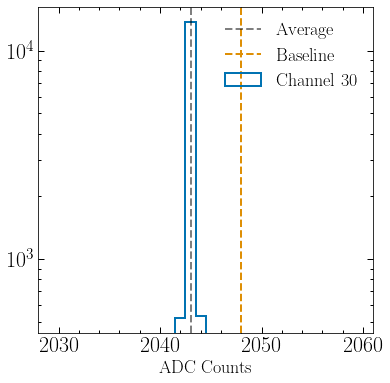

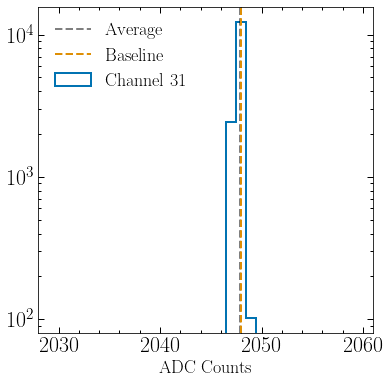

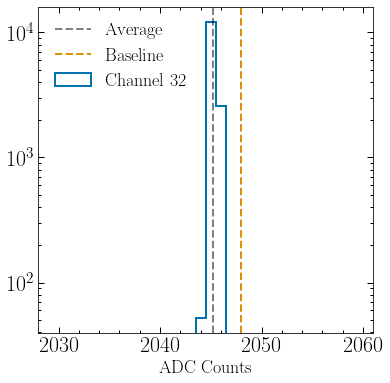

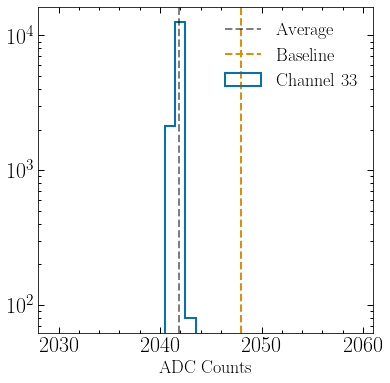

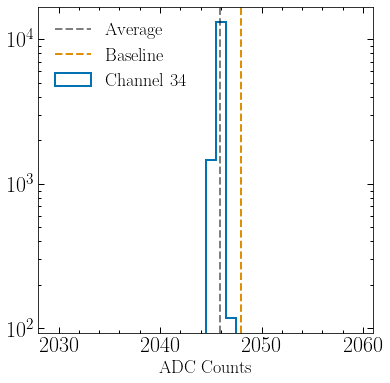

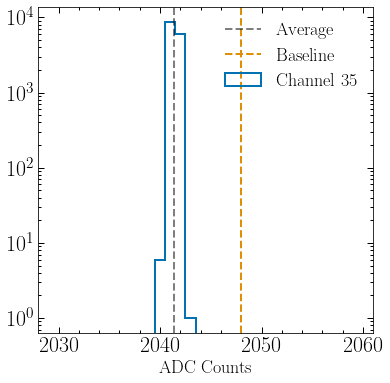

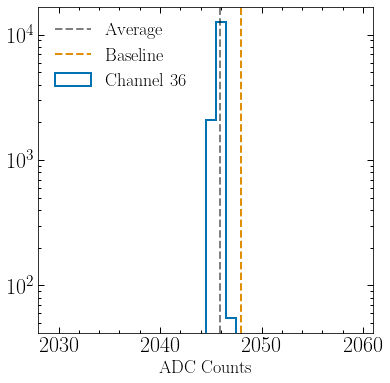

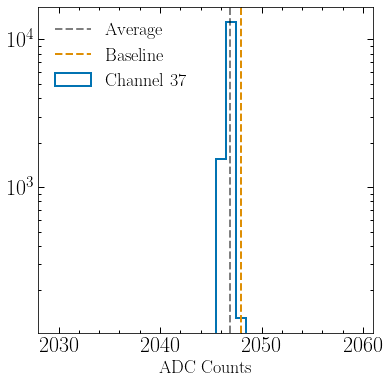

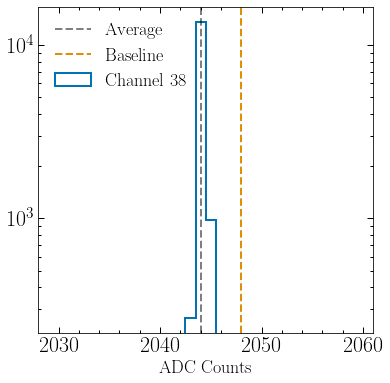

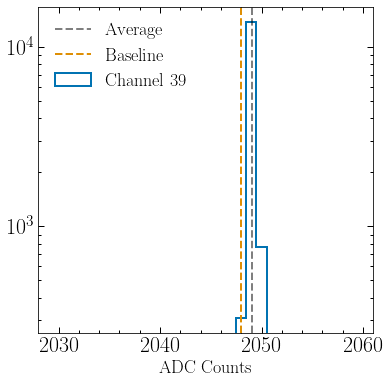

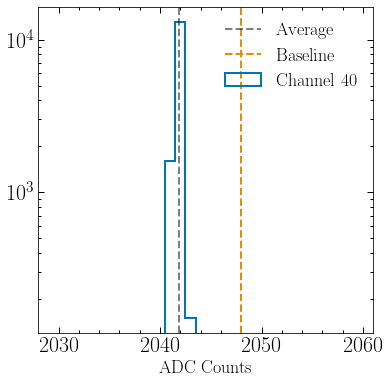

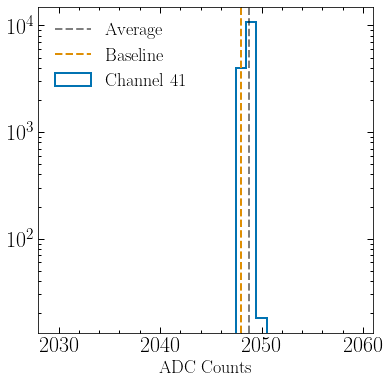

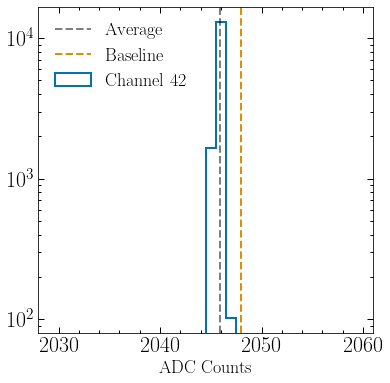

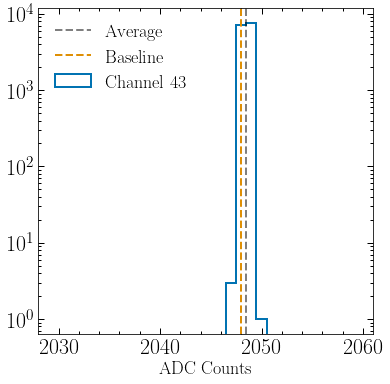

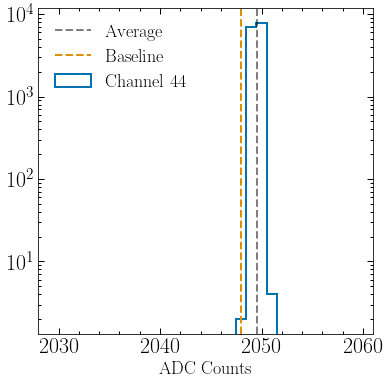

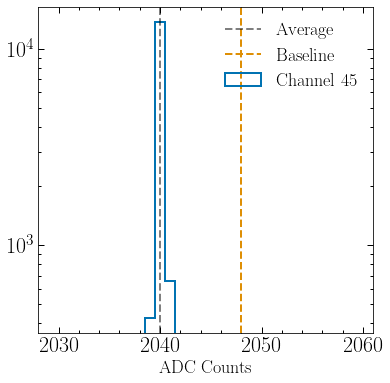

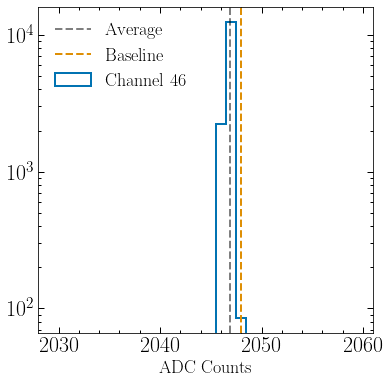

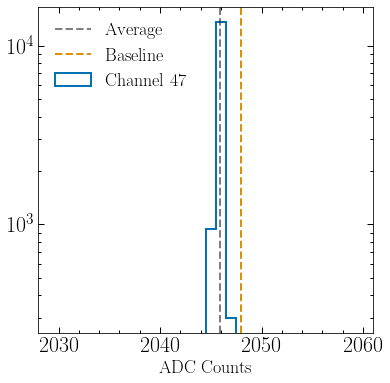

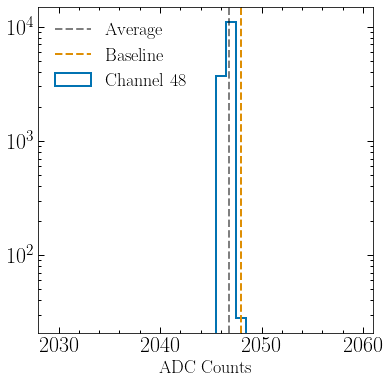

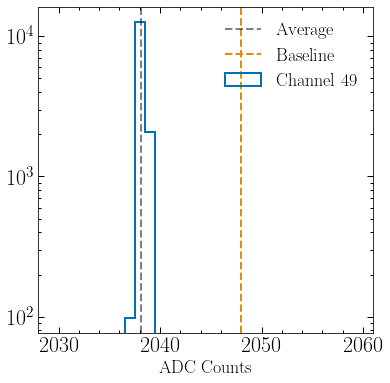

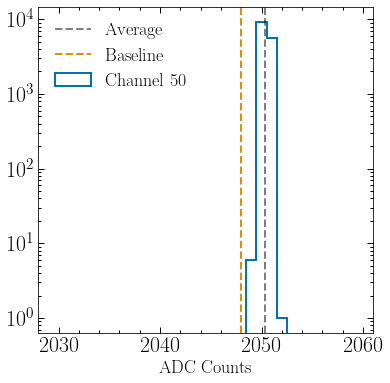

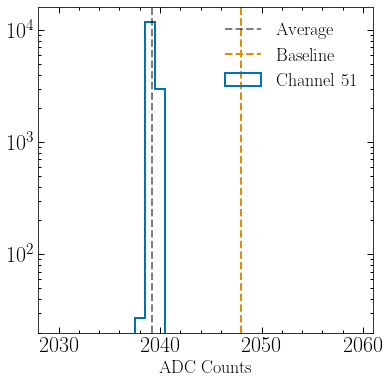

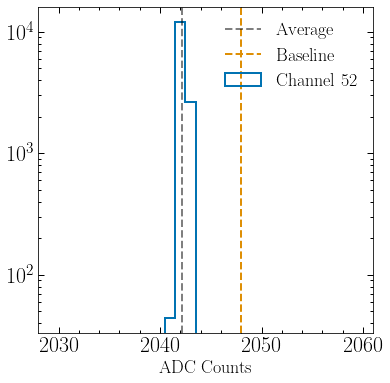

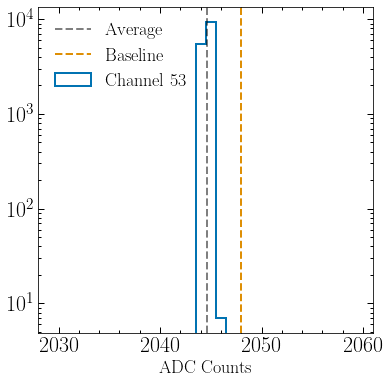

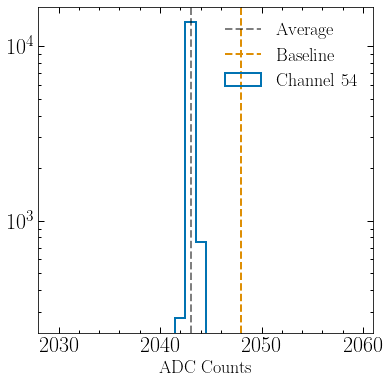

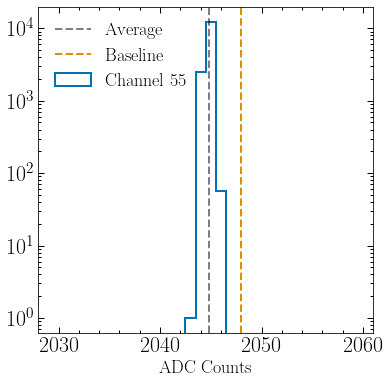

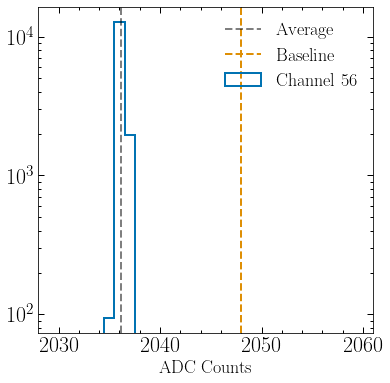

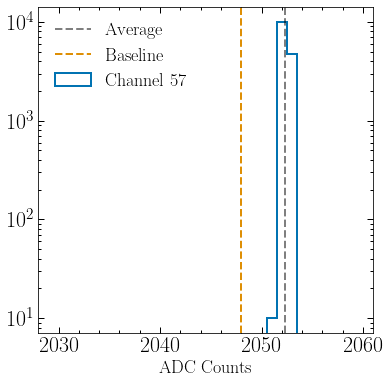

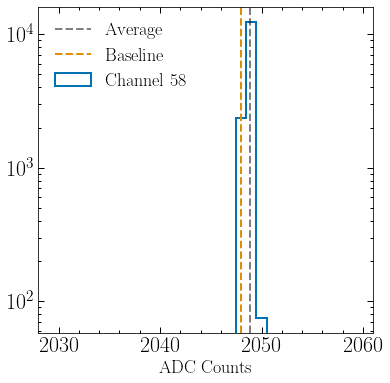

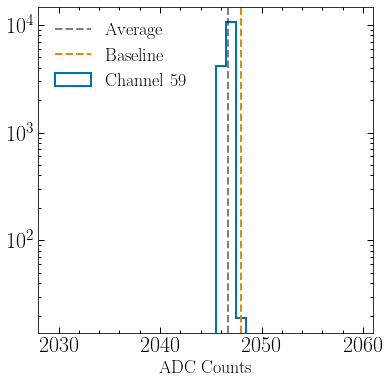

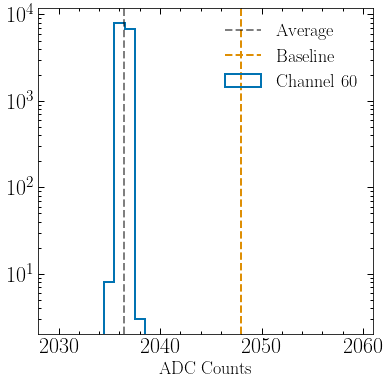

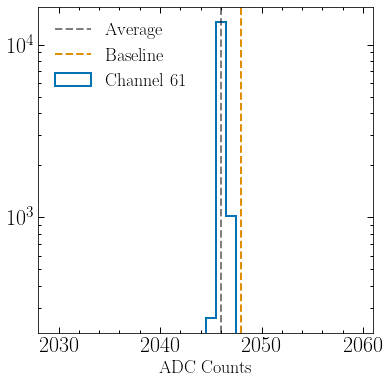

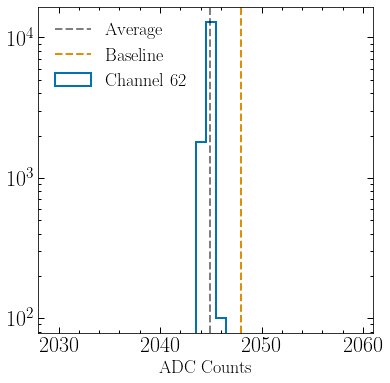

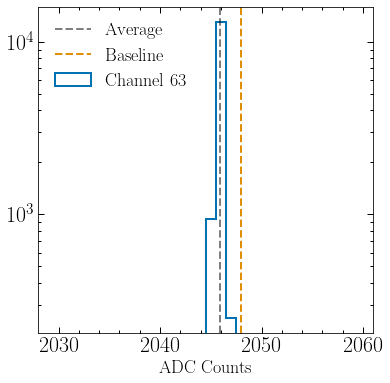

In [32]:
channels = [key for key in counts.keys()]
bins = np.linspace(2029.5, 2059.5, 31)

for channel in channels[:]:
    plt.hist(counts[channel], bins=bins, histtype='step', color=colors[0], label='Channel {}'.format(channel))
    plt.axvline(np.average(counts[channel]), color='k', ls='--', alpha=0.5, label='Average')
    plt.axvline(2048, color=colors[1], ls='--', label='Baseline')
    plt.legend(fontsize=18)
    plt.semilogy()
    plt.xlabel('ADC Counts')
    plt.show()

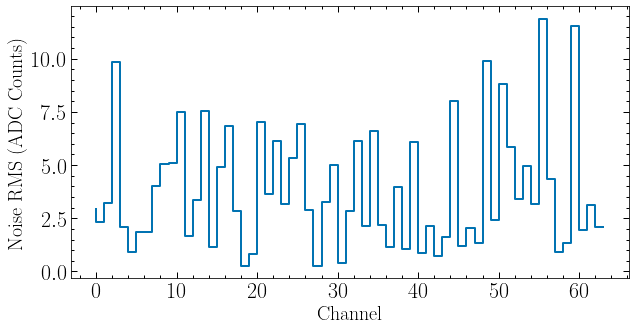

In [31]:
channels = [key for key in counts.keys()]
noise_rms = []
for ch in channels:
    mean = np.mean(counts[ch])
    squared_diffs = (counts[ch] - 2048) ** 2
    mean_squared_diff = np.mean(squared_diffs)
    noise_rms.append(np.sqrt(mean_squared_diff))
    
    
plt.figure(figsize=[10,5])
plt.step(channels, noise_rms, color=colors[0])
plt.xlabel('Channel', fontsize=20)
plt.ylabel('Noise RMS (ADC Counts)', fontsize=20)
plt.show()

## Crosstalk

In [ ]:
# plot adc amplitude vs channel number for each active channel configuration
# 3D hist of channel vs channel crosstalk

#The code above already sorta does that (output of noise_counts function is all adc counts per channel) so i can tweak it to also plot cross talk later